## Gather

In [618]:
import pandas as pd
import numpy as np
import re

import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [619]:
# Load WeRateDogs enhanced Twitter archive
twitter_archive = pd.read_csv('twitter-archive-enhanced-2.csv')

In [620]:
# Download tweet image predictions
img_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
with open(img_url.split('/')[-1], 'wb') as f:
    f.write(requests.get(img_url).content)
    
# Load the image predictions file
image_predictions = pd.read_csv(img_url.split('/')[-1], sep='\t')

In [621]:
# Load the json file into a DataFrame
df_list = []
with open('tweet-json.txt') as json_file:
    for line in json_file:
        line = json.loads(line)
        id_str = line['id']
        retweet_count = line['retweet_count']
        favorite_count = line['favorite_count']
        df_list.append({'tweet_id': id_str,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})
twitter_counts = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])    

## Access

In [622]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
274,840698636975636481,8.406983e+17,8.405479e+17,2017-03-11 22:59:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@0_kelvin_0 &gt;10/10 is reserved for puppos s...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
404,824025158776213504,NaN,NaN,2017-01-24 22:44:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""I wish we were dogs"" 14/10 for @BadlandsNPS h...",NaN,NaN,NaN,https://twitter.com/badlandsnps/status/8239662...,14,10,None,None,None,None,None
196,854732716440526848,NaN,NaN,2017-04-19 16:25:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Marlee. She fetched a flower and immed...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/854732716...,12,10,Marlee,None,None,None,None
338,832369877331693569,NaN,NaN,2017-02-16 23:23:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He fell asleep on a heating v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832369877...,11,10,Charlie,None,None,None,None
679,789137962068021249,NaN,NaN,2016-10-20 16:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a West Congolese Bugaboop Snu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789137962...,12,10,Bo,None,None,None,None


In [623]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [624]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [625]:
# Check duplicated rows
twitter_archive.tweet_id.duplicated().sum()

0

In [626]:
# Check dog names
twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
          ... 
Brandy       1
Brat         1
Blue         1
Fwed         1
Jareld       1
Name: name, Length: 957, dtype: int64

In [627]:
# Check rating numerator
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [628]:
twitter_archive[twitter_archive.text.str.contains(r'\d+\.\d*\/\d+')][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
45,This is Bella. She hopes her smile made you sm...,5,10
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
1689,I've been told there's a slight possibility he...,5,10
1712,Here we have uncovered an entire battalion of ...,26,10


In [629]:
for t in twitter_archive[twitter_archive.text.str.contains(r'\d+\.\d*\/\d+')].text:
    print(t)

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [630]:
# Check rating denominator
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [631]:
twitter_archive[twitter_archive.rating_denominator != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50


In [632]:
# Check if a dog is assigned more than one dog stage
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
for dog_stage in dog_stages:
    twitter_archive[dog_stage] = twitter_archive[dog_stage].apply(lambda x: 0 if x == 'None' else 1)

In [633]:
# Numbe of dog stages assigned to a dog
twitter_archive.loc[:, dog_stages].sum(axis=1).value_counts()

0    1976
1     366
2      14
dtype: int64

In [637]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
890,699323444782047232,https://pbs.twimg.com/media/CbR-9edXIAEHJKi.jpg,1,Labrador_retriever,0.309696,True,doormat,0.303700,False,sliding_door,0.077266,False
439,674436901579923456,https://pbs.twimg.com/media/CVwUyM9WwAAGDjv.jpg,1,acorn_squash,0.375392,False,Shih-Tzu,0.105416,True,Lhasa,0.072832,True
1153,732726085725589504,https://pbs.twimg.com/media/CisqdVcXEAE3iW7.jpg,1,Pomeranian,0.961902,True,Samoyed,0.024289,True,chow,0.005772,True
1319,756275833623502848,https://pbs.twimg.com/media/Cn7U2xlW8AI9Pqp.jpg,1,Airedale,0.602957,True,Irish_terrier,0.086981,True,bloodhound,0.086276,True
857,696877980375769088,https://pbs.twimg.com/media/CavO0uuWEAE96Ed.jpg,1,space_heater,0.206876,False,spatula,0.123450,False,vacuum,0.119218,False


In [638]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [639]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [640]:
# Chceck duplicated tweet ids
image_predictions.tweet_id.duplicated().sum()

0

In [641]:
# Chceck duplicated jpg_url
image_predictions.jpg_url.duplicated().sum()

66

In [642]:
twitter_counts.sample(5)

,tweet_id,retweet_count,favorite_count
1930,674024893172875264,1360,1914
674,789530877013393408,3942,13188
402,824297048279236611,4463,16625
747,779377524342161408,3613,9831
966,750147208377409536,1095,3409


In [643]:
twitter_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [644]:
twitter_counts.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [645]:
twitter_counts.tweet_id.duplicated().sum()

0

#### Quality

##### `twitter_archive` table

- timestamp and retweeted_status_timestamp columns should be DateTime type rather than object type.

- Some records are replies (in_reply_to_status_id = 78) and should be removed.

- Some records are retweets (retweeted_status_id = 181) and should be removed.

- Some values in name column are inaccurate such as a, None.

- Some values in rating_numerator are extracted inaccurately.

- rating_denominator should be 10 but some are 0, 2, 7, etc.

- 14 dogs are assigned to two dog stages and 1976 dogs are not assigned to any dog stage.

- Columns that won't be used for analysis should be dropped.

##### `image_predictions` table

- Number of records bewteen `image_predictions` table (2075) and `twitter_archive` table (2356) is not matched.

- Naming of values in columns p1, p2, p3 are inconsistent, some are lower cases and others are uppercases.

- There are 66 duplicated values in jpg_url column.

- There are records where p1_dog, p2_dog and p3_dog are False.

##### `twitter_counts` table

- Number of records bewteen `twitter_counts` table (2354) and `twitter_archive` table (2356) is not matched.

#### Tidiness

##### `twitter_archive` table

- Columns doggo, floofer, pupper, puppo are values rather than variables and should belong to dog stage variable.

##### `image_predictions` table

- Predicted dog breed should be part of `twitter_archive` table.

##### `twitter_counts` table

- retweet_count and favorite_count columns should be part of `twitter_archive` table.

## Clean

In [463]:
# Crate copies of the above dataframes
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_counts_clean = twitter_counts.copy()

### Clean `twitter_archive` table

#### Define

- Drop records that are either replies or retweets.
- Drop columns related to reply or retweet.

#### Code

In [464]:
twitter_archive_clean.shape

(2356, 17)

In [465]:
# Drop records that are replies
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]

# Drop records that are retweets
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

In [466]:
# Drop columns related to reply or retweet
twitter_archive_clean.drop(['in_reply_to_status_id', 
                            'in_reply_to_user_id', 
                            'retweeted_status_id', 
                            'retweeted_status_user_id',
                            'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [467]:
twitter_archive_clean.shape

(2097, 12)

#### Define

Correct the inaccurate values in rating_numerator column and their corrosponding rating_denominator column.

#### Code

In [468]:
# Convert the rating_numerator and rating_denominator columns to float type
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator.astype(np.float)
twitter_archive_clean.rating_denominator = twitter_archive_clean.rating_denominator.astype(np.float)

In [469]:
# Find rows where the text field contains fractional ratings
frac_idx = twitter_archive_clean[twitter_archive_clean.text.str.contains(r'\d+\.\d*\/\d+')].index

In [470]:
# Before cleaning
twitter_archive_clean.loc[frac_idx, ['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
45,5.0,10.0
695,75.0,10.0
763,27.0,10.0
1712,26.0,10.0


In [471]:
# Extract the correct rating numerator and denominator
for idx in frac_idx:
    rating = re.search('\d+\.\d*\/\d+', twitter_archive_clean.loc[idx, 'text']).group(0)
    twitter_archive_clean.loc[idx, 'rating_numerator'] = np.float(rating.split('/')[0])
    twitter_archive_clean.loc[idx, 'rating_denominator'] = np.float(rating.split('/')[1])

#### Test

In [472]:
twitter_archive_clean.loc[frac_idx, ['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
45,13.50,10.0
695,9.75,10.0
763,11.27,10.0
1712,11.26,10.0


#### Define

- Instead of fixing values in rating_denominator column that is not equal to 10, engineer a new feature called rating that is equal to the result of rating_numerator divided by rating_denominator.

- Drop the rating_numerator and rating_denominator columns.

#### Code

In [473]:
# Find records that rating_denominator is not equal to 10
twitter_archive_clean[twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
433,84.0,70.0
516,24.0,7.0
902,165.0,150.0
1068,9.0,11.0
1120,204.0,170.0
1165,4.0,20.0
1202,50.0,50.0
1228,99.0,90.0
1254,80.0,80.0
1274,45.0,50.0


In [474]:
# Engineer a new feature rating
twitter_archive_clean['rating'] = np.round(twitter_archive_clean.rating_numerator / twitter_archive_clean.rating_denominator, 2)

#### Test

In [475]:
twitter_archive_clean[twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'rating']]

,rating_numerator,rating_denominator,rating
433,84.0,70.0,1.20
516,24.0,7.0,3.43
902,165.0,150.0,1.10
1068,9.0,11.0,0.82
1120,204.0,170.0,1.20
1165,4.0,20.0,0.20
1202,50.0,50.0,1.00
1228,99.0,90.0,1.10
1254,80.0,80.0,1.00
1274,45.0,50.0,0.90


In [476]:
# Drop the rating_numerator and rating_denominator columns
twitter_archive_clean.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

#### Define

- Convert timestamp to DateTime type

#### Code

In [477]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [478]:
twitter_archive_clean.dtypes

tweet_id                       int64
timestamp        datetime64[ns, UTC]
source                        object
text                          object
expanded_urls                 object
name                          object
doggo                          int64
floofer                        int64
pupper                         int64
puppo                          int64
rating                       float64
dtype: object

#### Define

- Drop source, expanded_urls column
- Drop doggo, floofer, pupper, puppo columns

#### Code

In [479]:
twitter_archive_clean.drop(['source', 'expanded_urls'], axis=1, inplace=True)

In [480]:
# More than 83% of dog stages are missing, they are not used for later analysis
twitter_archive_clean.loc[:, dog_stages].sum(axis=1).value_counts() / twitter_archive_clean.shape[0]

0    0.839771
1    0.154983
2    0.005246
dtype: float64

In [481]:
twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [482]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweet_id   2097 non-null   int64              
 1   timestamp  2097 non-null   datetime64[ns, UTC]
 2   text       2097 non-null   object             
 3   name       2097 non-null   object             
 4   rating     2097 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(2)
memory usage: 178.3+ KB


#### Define

- Fix naming inconsistencies in prediction_1, prediction_2 adn prediction_3 columns.

#### Code

In [483]:
# Dog breed columns
dog_breed_cols = ['p1', 'p2', 'p3']

# Remove underscore and title each word
for col in dog_breed_cols:
    image_predictions_clean[col] = image_predictions_clean[col].str.replace('_', ' ').str.title()

#### Test

In [484]:
image_predictions_clean[dog_breed_cols]

,p1,p2,p3
0,Welsh Springer Spaniel,Collie,Shetland Sheepdog
1,Redbone,Miniature Pinscher,Rhodesian Ridgeback
2,German Shepherd,Malinois,Bloodhound
3,Rhodesian Ridgeback,Redbone,Miniature Pinscher
4,Miniature Pinscher,Rottweiler,Doberman
...,...,...,...
2070,Basset,English Springer,German Short-Haired Pointer
2071,Paper Towel,Labrador Retriever,Spatula
2072,Chihuahua,Malamute,Kelpie
2073,Chihuahua,Pekinese,Papillon


#### Define

- Drop duplicated values in jpg_url

#### Code

In [485]:
image_predictions_clean.drop_duplicates(subset=['jpg_url'], keep='first', inplace=True)

#### Test

In [486]:
image_predictions_clean.jpg_url.duplicated().sum()

0

#### Define

- Engineer a predicted dog breed column

#### Code

In [487]:
# Engineer a predicted dog breed column and asign default value NaN
image_predictions_clean['p_breed'] = np.nan

# If #1 prediction is a breed of dog, then use the #1 prediction. 
# Otherwise, use #2 or #3 prediction.
# If the top 3 prediction are False, then leave it as NaN
p1_true = image_predictions_clean['p1_dog'] == True
p2_true = image_predictions_clean['p2_dog']  == True
p3_true = image_predictions_clean['p3_dog']  == True
p1_true_idx = image_predictions_clean[p1_true].index
p2_true_idx = image_predictions_clean[(~p1_true) & p2_true].index
p3_true_idx = image_predictions_clean[(~p1_true) & (~p2_true) & p3_true].index

image_predictions_clean.loc[p1_true_idx, 'p_breed'] = image_predictions_clean.loc[p1_true_idx, 'p1']
image_predictions_clean.loc[p2_true_idx, 'p_breed'] = image_predictions_clean.loc[p2_true_idx, 'p2']
image_predictions_clean.loc[p3_true_idx, 'p_breed'] = image_predictions_clean.loc[p3_true_idx, 'p3']

#### Test

In [488]:
image_predictions_clean.iloc[:, 3:].sample(5)

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,p_breed
930,Hippopotamus,0.581403,False,Doormat,0.152445,False,Sea Lion,0.026364,False,NaN
1597,Norfolk Terrier,0.334436,True,Norwich Terrier,0.231573,True,Australian Terrier,0.214203,True,Norfolk Terrier
1126,Pomeranian,0.958834,True,Chihuahua,0.024099,True,Chow,0.003941,True,Pomeranian
1148,Lakeside,0.501767,False,Breakwater,0.051351,False,King Penguin,0.049444,False,NaN
1670,Doberman,0.909951,True,Kelpie,0.042649,True,Miniature Pinscher,0.023004,True,Doberman


#### Define

- Drop those columns that are used to engineered the p_breed column
- Drop records where the p_breed column is NaN

#### Code

In [489]:
### Drop unnecessary columns
image_predictions_clean.drop(['p1', 'p1_conf', 'p1_dog', 
                              'p2', 'p2_conf', 'p2_dog', 
                              'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

In [490]:
# Drop records where p_breed is Nan
image_predictions_clean = image_predictions_clean[image_predictions_clean.p_breed.notnull()]

#### Test

In [491]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher


In [492]:
image_predictions_clean.p_breed.isnull().sum()

0

#### Define

- Merge the `image_predictions_clean` table with `twitter_archive_clean` table.

#### Code

In [493]:
# Keep tweet_ids where there are dog breed predictions
twitter_archive_master = twitter_archive_clean.set_index('tweet_id').\
                         join(image_predictions_clean.set_index('tweet_id'), how='right')

#### Test

In [494]:
twitter_archive_master.head()

,timestamp,text,name,rating,jpg_url,img_num,p_breed
tweet_id,,,,,,,
666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,None,0.8,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel
666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,a,0.7,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone
666033412701032449,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-main...,a,0.9,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd
666044226329800704,2015-11-16 00:04:52+00:00,This is a purebred Piers Morgan. Loves to Netf...,a,0.6,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback
666049248165822465,2015-11-16 00:24:50+00:00,Here we have a 1949 1st generation vulpix. Enj...,None,0.5,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher


In [495]:
twitter_archive_master.shape

(1691, 7)

#### Define

- Merge the `twitter_counts` table with the `twitter_archive_master` table.

#### Code

In [501]:
twitter_archive_master = twitter_archive_master.join(twitter_counts.set_index('tweet_id'))

#### Test

In [503]:
twitter_archive_master.sample(5)

,timestamp,text,name,rating,jpg_url,img_num,p_breed,retweet_count,favorite_count
tweet_id,,,,,,,,,
724049859469295616,2016-04-24 01:38:33+00:00,This is Kreggory. He just took a look at his s...,Kreggory,1.0,https://pbs.twimg.com/media/CgxXf1TWYAEjY61.jpg,1,Border Collie,1984,4738
720785406564900865,2016-04-15 01:26:47+00:00,This is Archie. He hears everything you say. D...,Archie,1.2,https://pbs.twimg.com/media/CgC-gMCWcAAawUE.jpg,1,Chihuahua,866,3400
672139350159835138,2015-12-02 19:44:43+00:00,This pup has a heart on its ass and that is do...,None,1.2,https://pbs.twimg.com/media/CVPrLE2WwAELCxD.jpg,1,Rottweiler,792,1876
670444955656130560,2015-11-28 03:31:48+00:00,This is Paull. He just stubbed his toe. 10/10 ...,Paull,1.0,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English Springer,2153,7120
674053186244734976,2015-12-08 02:29:37+00:00,This is Stanley. Yes he is aware of the spoon'...,Stanley,1.0,https://pbs.twimg.com/media/CVq3zAaWwAA8vpk.jpg,1,Cardigan,1441,3576


In [504]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 666020888022790149 to 892177421306343426
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   timestamp       1666 non-null   datetime64[ns, UTC]
 1   text            1666 non-null   object             
 2   name            1666 non-null   object             
 3   rating          1666 non-null   float64            
 4   jpg_url         1691 non-null   object             
 5   img_num         1691 non-null   int64              
 6   p_breed         1691 non-null   object             
 7   retweet_count   1691 non-null   int64              
 8   favorite_count  1691 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 212.1+ KB


## Store

In [505]:
# Store the twitter_archive_master to .csv file
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

## Analyze & Visualize Data

### Insight #1

#### What are the Top 10 most popular Dog Breed?

In [534]:
twitter_archive_master.p_breed.value_counts()[:10]

Golden Retriever      158
Labrador Retriever    108
Pembroke               95
Chihuahua              91
Pug                    63
Toy Poodle             51
Chow                   48
Pomeranian             42
Samoyed                42
Malamute               33
Name: p_breed, dtype: int64

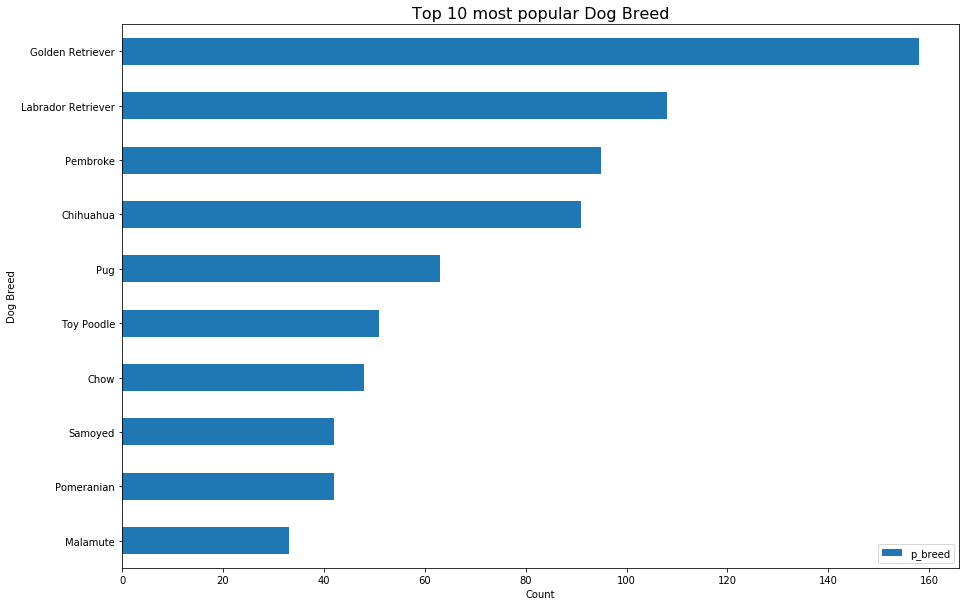

In [536]:
pd.DataFrame(twitter_archive_master.p_breed.value_counts()[:10]).sort_values('p_breed').plot(kind='barh', figsize=(15, 10))
plt.title('Top 10 most popular Dog Breed', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Dog Breed');

The top 10 most popular dog breeds are ordered as follow:
1. Golden Retriever
2. Labrador Retriever
3. Pembroke
4. Chihuahua
5. Pug
6. Toy Poodle
7. Chow
8. Pomeranian
9. Samoyed
10. Malamute        

### Insight #2

Does the Number of Retweet Count correlate with the Number of favorite Count?

In [539]:
twitter_archive_master[['retweet_count', 'favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.913243
favorite_count,0.913243,1.000000


Text(0, 0.5, 'Favorite Count')

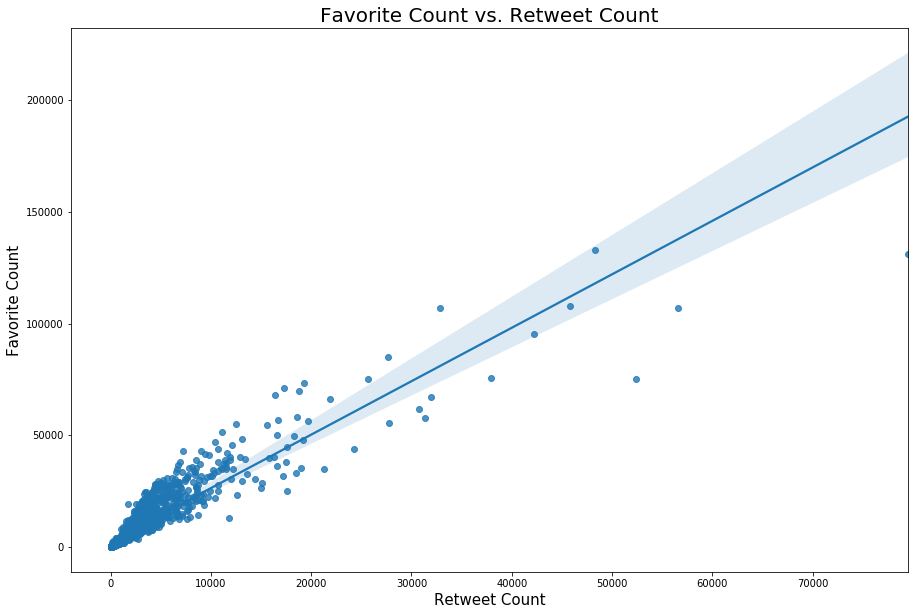

In [558]:
plt.figure(figsize=(15,10))
sns.regplot(x='retweet_count', y='favorite_count', data=twitter_archive_master)
plt.title('Favorite Count vs. Retweet Count', fontsize=20)
plt.xlabel('Retweet Count', fontsize=15)
plt.ylabel('Favorite Count', fontsize=15)

Based on the correlation coefficient (0.9132) and the visual assessment of the scatter plot between variables retweet_count and favorite_count, there is a strong and positive linear relationship between them.

### Insight #3

What the are Ratings Distribution?

In [597]:
twitter_archive_master.rating.describe()

count    1666.000000
mean        1.082641
std         0.188316
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         3.430000
Name: rating, dtype: float64

In [601]:
twitter_archive_master.rating.value_counts()

1.20    424
1.00    360
1.10    357
1.30    221
0.90    132
0.80     68
0.70     31
1.40     21
0.60     16
0.50     14
0.40      6
0.30      5
0.20      3
1.13      2
0.82      1
3.43      1
0.98      1
0.64      1
0.00      1
1.35      1
Name: rating, dtype: int64

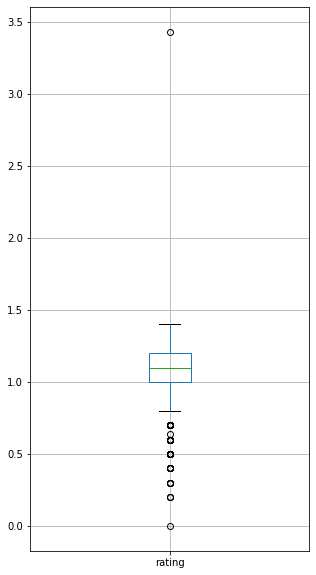

In [604]:
twitter_archive_master.boxplot(column=['rating'], figsize=(5, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE59486348>]],
      dtype=object)

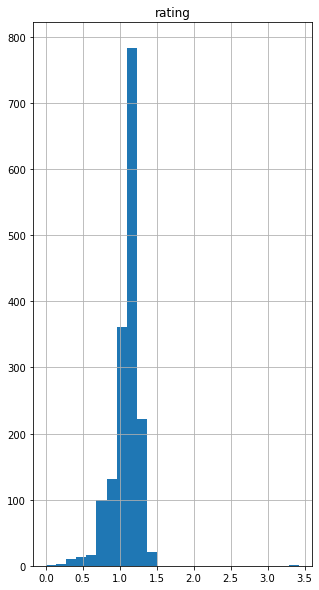

In [608]:
twitter_archive_master.hist(column=['rating'], bins=25, figsize=(5, 10))

The majority of the normalized ratings (rating numerator / rating denominator) is ranged from 1.0 to 1.2. Yet, the lowest rating is 0 and the highest one is 3.43.